# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Michal Novák (xnovak3g)

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [53]:
# init empty list
data = []

# open zip file
with ZipFile("logfiles.zip") as zf:
    # browse all files
    for filename in zf.namelist():
        # read only json files
        if filename.endswith('.json'):
            with zf.open(filename, "r") as f:
                # read file contents, parse json to dict and save to list
                data.append(json.loads(f.read().decode()))

# convert list to dataframe
df = pd.DataFrame(data)
# set types
df = df.astype({'run': int, 'runtime': float})
df

,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS
...,...,...,...,...
1195,config5,95,199.461297,SUCCESS
1196,config5,99,155.491930,SUCCESS
1197,config2,83,125.243690,SUCCESS
1198,config5,153,223.312938,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

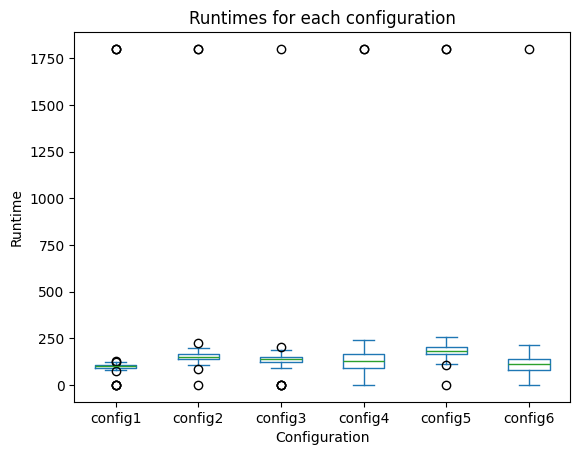

In [54]:
# plot
df[["runtime","configuration"]].plot.box("configuration", xlabel='Configuration', ylabel="Runtime")
plt.title("Runtimes for each configuration")
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_


Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

In [55]:
# use interquartile range to find 'outliers'
# compute values for each configuration
runtimes = df[['configuration','runtime']].groupby('configuration')
q1 = runtimes.quantile(0.25)
q3 = runtimes.quantile(0.75)
irq = q3 - q1

lower_bound = q1 - 1.5 * irq
upper_bound = q3 + 1.5 * irq

# add computed lower and upper bounds to dataframe (create copy of original dataframe)
df = df.join(lower_bound, on='configuration', rsuffix='_lower')
df = df.join(upper_bound, on='configuration', rsuffix='_upper')

# filter dataframe
df = df[(df['runtime'] >= df['runtime_lower']) & (df['runtime'] <= df['runtime_upper'])]
# remove added columns
df.drop(['runtime_lower', 'runtime_upper'], axis=1)

,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS
...,...,...,...,...
1195,config5,95,199.461297,SUCCESS
1196,config5,99,155.491930,SUCCESS
1197,config2,83,125.243690,SUCCESS
1198,config5,153,223.312938,SUCCESS


## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [56]:
# describe data 
df.groupby('configuration')['runtime'].describe()

,count,mean,std,min,25%,50%,75%,max
configuration,,,,,,,,
config1,190.0,99.449016,8.866788,80.124311,93.034540,99.799944,104.737728,121.904556
config2,195.0,151.688034,18.583050,107.522086,138.003905,151.516091,163.764042,196.293171
config3,194.0,138.292420,19.393682,90.567110,124.769359,138.448002,151.501348,185.413857
config4,198.0,126.317205,51.635948,0.000000,92.673117,129.887760,164.013094,241.987620
config5,196.0,184.049441,28.276656,114.035821,164.072975,183.916111,201.255548,255.807973
config6,199.0,110.422689,40.875754,2.124534,81.656211,111.043642,137.554141,215.295283


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

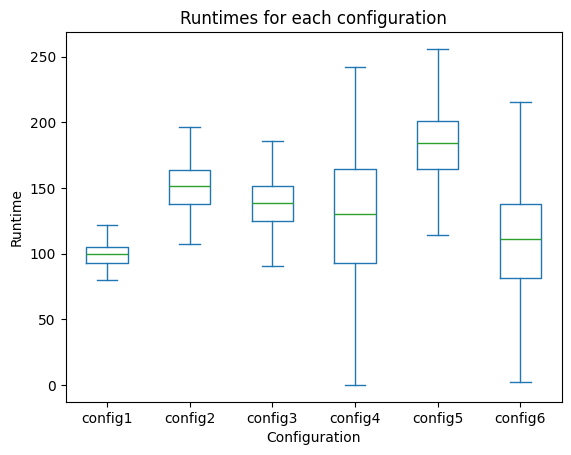

In [57]:
# plot
# df[["configuration", "runtime"]].groupby("configuration").boxplot(figsize=(10, 20))
# df.boxplot("runtime",by="configuration")
# plt.show()

df[["runtime","configuration"]].plot.box("configuration", xlabel='Configuration', ylabel="Runtime")
plt.title("Runtimes for each configuration")
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

config1: p-hodnota = 0.36605847080986026
config2: p-hodnota = 0.42148105777568556
config3: p-hodnota = 0.8374173595659102
config4: p-hodnota = 0.4063795373525325
config5: p-hodnota = 0.3730437861605712
config6: p-hodnota = 0.7656591016111406


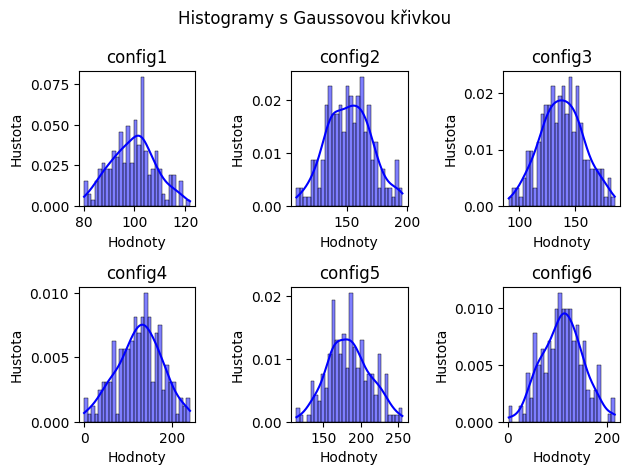

,A,B,t_stat
0,config1,config2,-35.342562
1,config1,config3,-25.325037
2,config1,config4,-7.211850
3,config1,config5,-39.911083
4,config1,config6,-3.697144
5,config2,config1,35.342562
6,config2,config3,6.954977
7,config2,config4,6.499588
8,config2,config5,-13.379387
9,config2,config6,12.941608


A
config1     True
config2    False
config3    False
config4    False
config5    False
config6    False
Name: t_stat, dtype: bool

In [73]:
# extract data for each configuration
data_dict = df.groupby('configuration')['runtime'].apply(np.array).to_dict()

# create subplots
fig, axes = plt.subplots(nrows=2, ncols=3) 
axes_lin = axes.reshape(-1)

# check if data have normal distribution
for index, (config, data) in enumerate(data_dict.items()):
    # Shapiro–Wilk test
    stat, p_value = stats.shapiro(data)
    print(f'{config}: p-hodnota = {p_value}')
    
    # histogram with Gaussian curve
    sns.histplot(data, kde=True, stat="density", bins=30, color='blue', ax=axes_lin[index])
    axes_lin[index].set_xlabel('Hodnoty')
    axes_lin[index].set_ylabel('Hustota')
    axes_lin[index].set_title(config)

# show plot
fig.suptitle(f'Histogramy s Gaussovou křivkou')
fig.tight_layout()
plt.show()

results = []
for index, (config1, data1) in enumerate(data_dict.items()):
    for config2, data2 in list(data_dict.items()):
        if config1 == config2:
            continue
        t_stat, _ = stats.ttest_ind(data1, data2, equal_var=False)
        results.append({'A': config1, 'B': config2, 't_stat': t_stat})

# compare results
rdf = pd.DataFrame(results)
all_negative = lambda x: max(x) < 0
display(rdf)

rdf.groupby('A')['t_stat'].apply(all_negative)


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_
Podle p-hodnot Shapiro–Wilk testu nemůžeme vyloučit, že data mají normální rozložení. Histogram proložený gausovou křivkou připomíná normální rozložení. Budeme tedy zkoumat data testy pro normální rozložení.

Zkoumat se budou běhy jednotlivých konfigurací algoritmů. Pro porovnání 2 konfigurací s normálním rozložením je vhodný dvouvýběrový Studentův t-test. Prvně ale musíme určit, zda jsou dat závislá, či nezávislá. V zadání je napsáno "budete analyzovat časy běhu šesti různých konfigurací algoritmů", z čehož je vyvodit, že data jsou nezívislá, jelikož se neprovádělo měření nad jedním algoritmem, ale nad více algoritmy. Data tedy musí být analyzována nepárovým t-testem.

Hypotézy budou stanoveny následovně:
- $H_0$: Obě porovnávané konfigurace mají stejný průměr
- $H_1$: Obě porovnávané konfigurace mají různý průměr




### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [59]:
# TODO vlastni implementace zvoleneho testu

# 1/(N-1) * SUM((x_i-x_mean)^2)
def std_squared(x: np.ndarray, mean: float) -> None:
    # sum 'insides'
    tmp = [(xi - mean)**2 for xi in x]
    
    # sum
    tmp_sum = sum(tmp)
    
    # divide by (count-1)
    return tmp_sum/(len(x)-1)
    

def independent_t_test(x1: np.ndarray, x2: np.ndarray) -> float:
    x1_mean = x1.mean()
    x2_mean = x2.mean()
    
    std_1_squared = std_squared(x1, x1_mean)
    std_2_squared = std_squared(x2, x2_mean)
    
    d = (x1_mean-x2_mean)/(((std_1_squared/len(x1))+(std_2_squared/len(x2)))**(1/2))
    return d
    
    
independent_t_test(np.array(data_dict['config1']), np.array(data_dict['config2']))


-35.34256160327792

In [70]:
# run independent t-test for every configuration pair
rdf['custom_t_stat'] = rdf.apply(lambda row: independent_t_test(data_dict[row['A']], data_dict[row['B']]), axis=1)

# compare custom t-test result with scipy t-test result
rdf['comparation'] = rdf.apply(lambda row: abs(row['custom_t_stat'] - row['t_stat']) < 1e-9, axis=1)
rdf

,A,B,t_stat,custom_t_stat,comparation
0,config1,config2,-35.342562,-35.342562,True
1,config1,config3,-25.325037,-25.325037,True
2,config1,config4,-7.211850,-7.211850,True
3,config1,config5,-39.911083,-39.911083,True
4,config1,config6,-3.697144,-3.697144,True
5,config2,config1,35.342562,35.342562,True
6,config2,config3,6.954977,6.954977,True
7,config2,config4,6.499588,6.499588,True
8,config2,config5,-13.379387,-13.379387,True
9,config2,config6,12.941608,12.941608,True
